### Coursework

В этом конкурсе вашей задачей будет предсказать цену квартир в test.csv. Вам будет предоставлено два набора данных: train.csv (содержит все характеристики и цены квартир) и test.csv (только характеристики).

Ваша задача в этом соревновании - предсказать цены на квартиру в датасете test.csv. Вам будут даны два набора данных: train.csv (содержит признаки и цены на квартиру) и test.csv (только признаки).

Ссылка для приглашения на этот конкурс: https://www.kaggle.com/t/b4c9382d4f934176af9fe860b1976528\

Метрикой оценки является Коэффициент детерминации :  $ R^2=1−\frac{σ^2}{σ^2_y} $

In [3074]:
import numpy as np
import pandas as pd
import random
import sklearn

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler, StandardScaler,  MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor # для непрерывной величины
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# графики строить в ячейках 
%matplotlib inline

In [3075]:
# убираем сообщение об ошибках
import warnings
warnings.filterwarnings('ignore')

In [3076]:
# увеличиваем шрифты
matplotlib.rcParams.update({'font.size': 14})

In [3077]:
# функция для построения построения двух графиков

def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Пути к дирректориям и файлам

In [3078]:
TRAIN_DATASET_PATH = 'C:\project_data_from_kaggle/train.csv'  # X_train, X_valid
TEST_DATASET_PATH = 'C:\project_data_from_kaggle/test.csv'

#### Описание датасета

__Id__ - идентификационный номер квартиры\
__DistrictId__ - идентификационный номер района\
__Rooms__ - количество комнат\
__Square__ - площадь\
__LifeSquare__ - жилая площадь\
__KitchenSquare__ - площадь кухни\
__Floor__ - этаж\
__HouseFloor__ - количество этажей в доме\
__HouseYear__ - год постройки дома\
__Ecology_1, Ecology_2, Ecology_3__ - экологические показатели местности\
__Social_1, Social_2, Social_3__ - социальные показатели местности\
__Healthcare_1, Helthcare_2__ - показатели местности, связанные с охраной здоровья\
__Shops_1, Shops_2__ - показатели, связанные с наличием магазинов, торговых центров\
__Price__ - цена квартиры

#### Загрузка данных

In [3079]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855


In [3080]:
X_test = pd.read_csv(TEST_DATASET_PATH)
X_test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B


In [3081]:
train_df.shape

(10000, 20)

In [3082]:
X_test.shape

(5000, 19)

#### Приведение типов

In [3083]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [3084]:
X_test.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [3085]:
# что бы не забыть обработать эти категориальные признаки
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)


#### Делаем EDA  (первичный визуальный анализ данных) для:

Исправления выбросов\
Заполнения NaN\
Идей для генерации новых фич

#### Целевая переменная

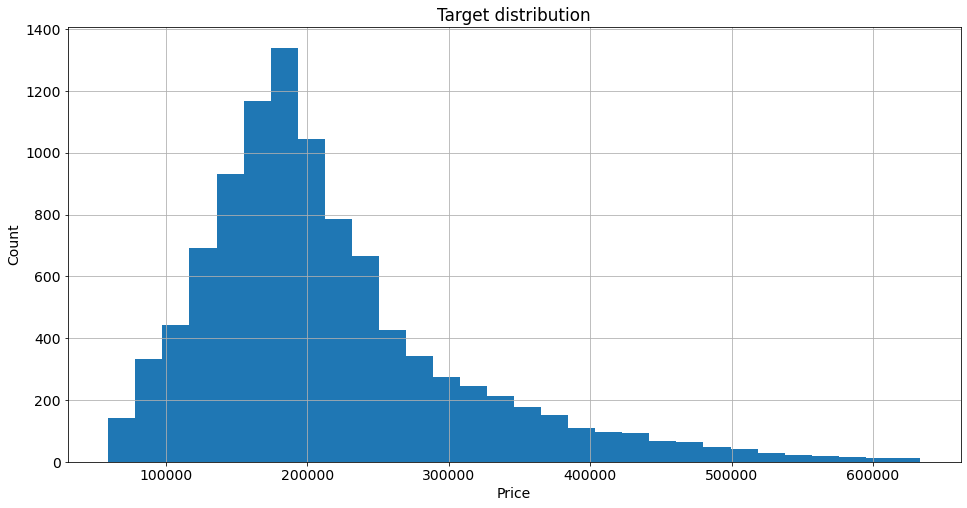

In [3086]:
# смотрим распределение целевой переменной
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

## Разбиваем датасет train_df на два датасета X_train и  X_valid

In [3087]:
#  Необходимо разбить train_df на два датасета - обучаемый и валидационный

X_train, X_valid = train_test_split(train_df, test_size=0.5, random_state=45)

# другая запись метода
#train, validate, test = np.split(df, [int(.7*len(df)), int(.85*len(df))])

In [3088]:
X_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3288,2387,167,3.0,67.125192,44.111898,9.0,15,14.0,1974,0.050272,B,B,21,4231,14,1020.0,0,3,B,364020.418544
2361,8720,92,3.0,77.462932,47.945290,9.0,22,22.0,1995,0.460556,B,B,20,4386,14,NaN,1,5,B,401899.146615
9081,9383,24,2.0,88.407297,NaN,0.0,2,0.0,1977,0.111627,B,B,50,12238,8,1970.0,2,3,B,427473.921933
5956,16049,21,1.0,33.725220,21.606262,5.0,3,5.0,1970,0.194489,B,B,47,8004,3,125.0,3,5,B,151827.177876
2965,15528,66,3.0,79.489579,47.728357,12.0,17,17.0,2001,0.111627,B,B,50,12238,8,1970.0,2,3,B,460008.063894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8772,12030,11,2.0,54.292744,30.671636,8.0,7,12.0,1980,0.000170,B,B,36,5992,0,NaN,1,1,B,205278.340909
163,11805,6,1.0,42.730884,NaN,1.0,17,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,129409.393794
6012,5788,69,3.0,76.441588,45.867318,10.0,10,17.0,2001,0.000991,B,B,33,6783,3,NaN,1,9,B,494798.660340
6558,12523,54,2.0,78.537626,76.021994,1.0,2,1.0,2014,0.006076,B,B,30,5285,0,645.0,6,6,B,351111.994305


In [3089]:
X_valid

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4132,13457,6,1.0,40.326128,NaN,0.0,16,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,123044.213699
6553,13846,22,2.0,61.221971,NaN,1.0,3,25.0,1977,0.118537,B,B,30,6207,1,1183.0,1,0,B,177351.068835
7604,5256,37,2.0,38.452646,26.290977,6.0,9,9.0,1967,0.178917,B,B,18,3594,4,192.0,1,5,B,201999.568201
585,16253,23,1.0,45.031389,NaN,1.0,9,25.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,111544.893203
5924,13818,7,3.0,115.254741,56.404018,19.0,16,17.0,2012,0.035145,B,B,42,9292,3,2620.0,0,3,B,565355.938997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5027,2947,24,2.0,38.427761,26.170250,6.0,3,12.0,1969,0.111627,B,B,50,12238,8,1970.0,2,3,B,203201.637228
2081,9815,12,3.0,85.780610,51.107723,8.0,2,12.0,1996,0.090799,B,B,74,19083,2,NaN,5,15,B,291231.806250
9570,1791,7,2.0,45.594950,32.092122,6.0,5,4.0,1962,0.035145,B,B,42,9292,3,2620.0,0,3,B,201703.778451
8839,12226,15,3.0,101.722561,53.829399,12.0,16,16.0,2008,0.158249,B,B,21,5731,0,NaN,1,0,B,384904.132528


### Количественные переменные

In [3090]:
# много странностей и выбросов
X_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,5000.000000,5000.000000,3958.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,2627.000000,5000.000000,5000.000000,5000.000000
mean,1.883600,56.047101,37.772819,6.338400,8.485000,12.613800,1984.631800,0.120482,24.782600,5359.741600,7.83780,1151.067758,1.348800,4.239200,213428.918031
std,0.850056,21.295146,120.199326,28.918733,5.201998,6.830313,18.358193,0.118693,17.410708,3979.874773,23.06769,1030.889914,1.505587,4.762197,91895.003845
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1910.000000,0.000000,0.000000,168.000000,0.00000,30.000000,0.000000,0.000000,60828.260686
25%,1.000000,41.298710,22.637107,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.00000,350.000000,0.000000,1.000000,153941.123677
50%,2.000000,52.082516,32.463589,6.000000,7.000000,12.000000,1977.000000,0.075779,25.000000,5285.000000,2.00000,900.000000,1.000000,3.000000,192306.013040
75%,2.000000,65.863037,44.871845,9.000000,12.000000,17.000000,2000.000000,0.195781,35.000000,7227.000000,5.00000,1548.000000,3.000000,6.000000,248515.785235
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.00000,4849.000000,6.000000,23.000000,633233.466570


In [3091]:
# много странностей и выбросов
X_valid.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,5000.000000,5000.000000,3929.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,2575.000000,5000.000000,5000.000000,5000.000000
mean,1.897400,56.584449,36.622240,6.208200,8.568400,12.605000,5.995701e+03,0.117233,24.591400,5344.573200,8.240600,1134.576311,1.290200,4.223400,214848.796767
std,0.828861,20.818296,19.408413,28.201303,5.280199,6.721876,2.835502e+05,0.119346,17.654903,4033.928926,24.572966,1011.998227,1.481088,4.850546,93843.227630
min,0.000000,1.988943,0.641822,0.000000,1.000000,0.000000,1.912000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,42.122513,23.034347,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153822.344768
50%,2.000000,52.797939,33.009631,6.000000,7.000000,14.000000,1.977000e+03,0.072158,25.000000,5285.000000,2.000000,920.000000,1.000000,3.000000,192205.809853
75%,2.000000,65.953603,45.382156,9.000000,12.000000,17.000000,2.002000e+03,0.194489,36.000000,7287.000000,4.000000,1548.000000,2.000000,5.250000,250178.792532
max,10.000000,604.705972,461.463614,1970.000000,37.000000,99.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,625820.041178


### Категориальные переменные

#### X_train

In [3092]:
cat_colnames = X_train.select_dtypes(include='object').columns.tolist()
cat_colnames

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [3093]:
# перекос данных  - полезность данных
for cat_colnames in cat_colnames[2:]:
    print (str(cat_colnames) + '\n\n' + str(X_train[cat_colnames].value_counts()) + '\n')

Ecology_2

B    4948
A      52
Name: Ecology_2, dtype: int64

Ecology_3

B    4861
A     139
Name: Ecology_3, dtype: int64

Shops_2

B    4599
A     401
Name: Shops_2, dtype: int64



#### X_valid

In [3094]:
cat_colnames = X_valid.select_dtypes(include='object').columns.tolist()
cat_colnames

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [3095]:
# перекос данных  - полезность данных
for cat_colnames in cat_colnames[2:]:
    print (str(cat_colnames) + '\n\n' + str(X_valid[cat_colnames].value_counts()) + '\n')

Ecology_2

B    4955
A      45
Name: Ecology_2, dtype: int64

Ecology_3

B    4864
A     136
Name: Ecology_3, dtype: int64

Shops_2

B    4576
A     424
Name: Shops_2, dtype: int64



### Обработка выбросов

Что можно делать с ними?

Выкинуть эти данные (только на трейне, на тесте ничего не выкидываем)\
Заменять выбросы разными методами (медианы, средние значения, np.clip и т.д.)\
Делать/не делать дополнительную фичу\
Ничего не делать

#### X_train

In [3096]:
X_train[['Rooms','Square','LifeSquare','KitchenSquare']].value_counts()

Rooms  Square     LifeSquare  KitchenSquare
0.0    38.697117  19.345131   9.0              1
2.0    61.334968  4.091945    1.0              1
       61.392429  62.426932   10.0             1
       61.400054  65.224603   0.0              1
       61.464284  30.289514   13.0             1
                                              ..
1.0    47.439867  47.204497   1.0              1
       47.544521  21.484714   8.0              1
       47.556290  21.219980   8.0              1
       47.556592  44.409813   1.0              1
19.0   42.006046  21.779288   7.0              1
Length: 3958, dtype: int64

#### X_valid

In [3097]:
X_valid[['Rooms','Square','LifeSquare','KitchenSquare']].value_counts()

Rooms  Square     LifeSquare  KitchenSquare
0.0    2.377248   0.873147    0.0              1
2.0    62.177565  34.794601   10.0             1
       62.204123  33.160297   10.0             1
       62.227202  32.867867   10.0             1
       62.254114  37.160377   7.0              1
                                              ..
1.0    52.787090  5.600609    1.0              1
       53.036291  24.200116   13.0             1
       53.043303  19.138688   13.0             1
       53.084834  17.814096   13.0             1
10.0   60.871266  38.420681   10.0             1
Length: 3929, dtype: int64

#### X_test

In [3098]:
X_test['Id'].duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
4995    False
4996    False
4997    False
4998    False
4999    False
Name: Id, Length: 5000, dtype: bool

In [3099]:
X_test[['Rooms','Square','LifeSquare','KitchenSquare']].value_counts()

Rooms  Square     LifeSquare  KitchenSquare
0.0    76.345154  42.820796   12.0             1
2.0    62.768905  61.244800   0.0              1
       62.827011  59.637894   10.0             1
       62.836350  4.812338    1.0              1
       62.853794  34.978464   5.0              1
                                              ..
1.0    56.743845  32.964925   9.0              1
       56.749665  41.934181   10.0             1
       56.758712  54.912313   1.0              1
       56.885763  55.881861   0.0              1
17.0   52.866107  32.528342   8.0              1
Length: 3959, dtype: int64

### Обработка выбросов и пропусков

### *Rooms*

In [3100]:
# замена значений определённых как выбросы в  X_train, 'Rooms' [0, 6, 10, 19] на средние значения

X_train.loc[X_train['Rooms'].isin([0, 10, 19]), 'Rooms'] = int(X_train['Rooms'].median())

# можно также так
#X_train['Rooms_outlier'] = 0
#X_train.loc[(X_train['Rooms'] == 0) | (X_train['Rooms'] >= 6), 'Rooms_outlier'] = 1
#X_train.head()

In [3101]:
# проверяем X_train
X_train['Rooms'].value_counts()

2.0    1935
1.0    1876
3.0    1104
4.0      74
5.0      11
Name: Rooms, dtype: int64

In [3102]:
# замена значений определённых как выбросы в  X_valid, 'Rooms' [0, 10] на средние значения

X_valid.loc[X_valid['Rooms'].isin([0, 10]), 'Rooms'] = int(X_valid['Rooms'].median())

# можно также так
#X_valid['Rooms_outlier'] = 0
#X_valid.loc[(X_valid['Rooms'] == 0) | (X_valid['Rooms'] >= 6), 'Rooms_outlier'] = 1
#X_valid.head()

In [3103]:
# проверяем X_valid
X_valid['Rooms'].value_counts()

2.0    1956
1.0    1829
3.0    1131
4.0      76
5.0       7
6.0       1
Name: Rooms, dtype: int64

In [3104]:
# замена значений определённых как выбросы в  X_test, 'Rooms' [0, 6, 17] на средние значения

X_test.loc[X_test['Rooms'].isin([0, 17]), 'Rooms'] = int(X_test['Rooms'].median())

# можно также так
#X_test['Rooms_outlier'] = 0
#X_test.loc[(X_test['Rooms'] == 0) | (X_test['Rooms'] >= 6), 'Rooms_outlier'] = 1
#X_test.head()

In [3105]:
# проверяем X_test
X_test['Rooms'].value_counts()

2.0    2033
1.0    1769
3.0    1099
4.0      90
5.0       7
6.0       2
Name: Rooms, dtype: int64

### *Square	LifeSquare	KitchenSquare*

#### X_train

In [3106]:
X_train[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,5000.000000,3958.000000,5000.000000
mean,56.047101,37.772819,6.338400
std,21.295146,120.199326,28.918733
min,1.136859,0.370619,0.000000
25%,41.298710,22.637107,1.000000
50%,52.082516,32.463589,6.000000
75%,65.863037,44.871845,9.000000
max,641.065193,7480.592129,2014.000000


In [3107]:
condition = (X_train['Square'].isna()) | (X_train['Square'] > X_train['Square'].quantile(.97))
X_train.loc[condition, 'Square'] = X_train['Square'].median()
X_train.loc[train_df['Square'] < 10, 'Square'] = 10

condition = (X_train['LifeSquare'].isna()) | (X_train['LifeSquare'] > X_train['LifeSquare'].quantile(.97))
X_train.loc[condition, 'LifeSquare'] = X_train['LifeSquare'].median()
X_train.loc[X_train['LifeSquare'] < 10, 'LifeSquare'] = 10

condition = (X_train['KitchenSquare'].isna()) | (X_train['KitchenSquare'] > X_train['KitchenSquare'].quantile(.97))
X_train.loc[condition, 'KitchenSquare'] = X_train['KitchenSquare'].median()
X_train.loc[X_train['KitchenSquare'] < 1, 'KitchenSquare'] = 1


# доп инструменты
#X_train = X_train[X_train['Square'].isnull() |
#                    (X_train['Square'] < X_train['Square'].quantile(.97)) &
#                    (X_train['Square'] > X_train['Square'].quantile(.04))]
#
#X_train = X_train[train_df['LifeSquare'].isnull() |
#                    (X_train['LifeSquare'] < X_train['LifeSquare'].quantile(.97)) &
#                    (X_train['LifeSquare'] > X_train['LifeSquare'].quantile(.03))]
#
#X_train = X_train[X_train['KitchenSquare'].isnull() |
#                    (X_train['KitchenSquare'] < X_train['KitchenSquare'].quantile(.97)) &
#                    (X_train['KitchenSquare'] > X_train['KitchenSquare'].quantile(.1))]

In [3108]:
X_train[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,5000.000000,5000.000000,5000.000000
mean,54.008168,33.718468,5.573800
std,15.531869,12.246774,3.506767
min,10.000000,10.000000,1.000000
25%,41.298710,24.549753,1.000000
50%,52.082350,32.463589,6.000000
75%,64.320046,39.246278,8.000000
max,96.924231,78.205032,12.000000


#### X_valid

In [3109]:
X_valid[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,5000.000000,3929.000000,5000.000000
mean,56.584449,36.622240,6.208200
std,20.818296,19.408413,28.201303
min,1.988943,0.641822,0.000000
25%,42.122513,23.034347,1.000000
50%,52.797939,33.009631,6.000000
75%,65.953603,45.382156,9.000000
max,604.705972,461.463614,1970.000000


In [3110]:
condition = (X_valid['Square'].isna()) | (X_valid['Square'] > X_valid['Square'].quantile(.97))
X_valid.loc[condition, 'Square'] = X_valid['Square'].median()
X_valid.loc[X_valid['Square'] < 10, 'Square'] = 10

condition = (X_valid['LifeSquare'].isna()) | (X_valid['LifeSquare'] > X_valid['LifeSquare'].quantile(.97))
X_valid.loc[condition, 'LifeSquare'] = X_valid['LifeSquare'].median()
X_valid.loc[X_valid['LifeSquare'] < 10, 'LifeSquare'] = 10

condition = (X_valid['KitchenSquare'].isna()) | (X_valid['KitchenSquare'] > X_valid['KitchenSquare'].quantile(.97))
X_valid.loc[condition, 'KitchenSquare'] = X_valid['KitchenSquare'].median()
X_valid.loc[X_valid['KitchenSquare'] < 1, 'KitchenSquare'] = 1

In [3111]:
X_valid[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,5000.000000,5000.000000,5000.000000
mean,54.532859,34.341756,5.545200
std,15.418258,12.060016,3.535995
min,10.000000,10.000000,1.000000
25%,42.122513,27.126252,1.000000
50%,52.792514,33.009631,6.000000
75%,64.334665,39.993711,8.000000
max,98.114681,79.494457,12.000000


#### X_test

In [3112]:
X_test[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,5000.000000,3959.000000,5000.000000
mean,56.449500,36.158810,5.976800
std,19.092787,17.825287,9.950018
min,1.378543,0.333490,0.000000
25%,41.906231,23.092026,1.000000
50%,52.921340,32.925087,6.000000
75%,66.285129,45.174091,9.000000
max,223.453689,303.071094,620.000000


In [3113]:
condition = (X_test['Square'].isna()) | (X_test['Square'] > X_test['Square'].quantile(.97))
X_test.loc[condition, 'Square'] = X_test['Square'].median()
X_test.loc[X_test['Square'] < 10, 'Square'] = 10

condition = (X_test['LifeSquare'].isna()) | (X_test['LifeSquare'] > X_test['LifeSquare'].quantile(.97))
X_test.loc[condition, 'LifeSquare'] = X_test['LifeSquare'].median()
X_test.loc[X_test['LifeSquare'] < 10, 'LifeSquare'] = 10

condition = (X_test['KitchenSquare'].isna()) | (X_test['KitchenSquare'] > X_test['KitchenSquare'].quantile(.97))
X_test.loc[condition, 'KitchenSquare'] = X_test['KitchenSquare'].median()
X_test.loc[X_test['KitchenSquare'] < 1, 'KitchenSquare'] = 1

In [3114]:
X_test[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,5000.000000,5000.000000,5000.000000
mean,54.591335,34.177946,5.597200
std,15.598000,12.135232,3.493965
min,10.000000,10.000000,1.000000
25%,41.906231,25.850152,1.000000
50%,52.919578,32.925087,6.000000
75%,64.891434,39.742316,8.000000
max,97.889332,78.137976,12.000000


### *Floor,HouseFloor*

#### X_train

In [3115]:
X_train[['Floor', 'HouseFloor']].describe()

,Floor,HouseFloor
count,5000.000000,5000.000000
mean,8.485000,12.613800
std,5.201998,6.830313
min,1.000000,0.000000
25%,4.000000,9.000000
50%,7.000000,12.000000
75%,12.000000,17.000000
max,42.000000,117.000000


In [3116]:
X_train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 33, 42], dtype=int64)

In [3117]:
(X_train['Floor'] > X_train['HouseFloor']).sum()

883

In [3118]:
X_train.loc[X_train['HouseFloor'] == 0, 'HouseFloor'] = X_train['HouseFloor'].median()

In [3119]:
np.random.seed(27)
floor_outliers = X_train[X_train['Floor'] > X_train['HouseFloor']].index
print(len(floor_outliers))

X_train.loc[floor_outliers, 'Floor'] = X_train.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

788


In [3120]:
# проверка
X_train['HouseFloor'] == 0  | (X_train['Floor'] > X_train['HouseFloor']).sum()

3288    False
2361    False
9081    False
5956    False
2965    False
        ...  
8772    False
163     False
6012    False
6558    False
7115    False
Name: HouseFloor, Length: 5000, dtype: bool

#### X_valid


In [3121]:
X_valid[['Floor', 'HouseFloor']].describe()

,Floor,HouseFloor
count,5000.000000,5000.000000
mean,8.568400,12.605000
std,5.280199,6.721876
min,1.000000,0.000000
25%,4.000000,9.000000
50%,7.000000,14.000000
75%,12.000000,17.000000
max,37.000000,99.000000


In [3122]:
X_valid['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 37],
      dtype=int64)

In [3123]:
(X_valid['Floor'] > X_valid['HouseFloor']).sum()

942

In [3124]:
X_valid.loc[X_valid['HouseFloor'] == 0, 'HouseFloor'] = X_valid['HouseFloor'].median()

In [3125]:
np.random.seed(27)
floor_outliers = X_valid[X_valid['Floor'] > X_valid['HouseFloor']].index
print(len(floor_outliers))

X_valid.loc[floor_outliers, 'Floor'] = X_valid.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

818


In [3126]:
# проверка
X_valid['HouseFloor'] == 0  | (X_valid['Floor'] > X_valid['HouseFloor']).sum()

4132    False
6553    False
7604    False
585     False
5924    False
        ...  
5027    False
2081    False
9570    False
8839    False
1196    False
Name: HouseFloor, Length: 5000, dtype: bool

#### X_test

In [3127]:
X_test[['Floor', 'HouseFloor']].describe()

,Floor,HouseFloor
count,5000.000000,5000.000000
mean,8.632000,12.601000
std,5.483228,6.789213
min,1.000000,0.000000
25%,4.000000,9.000000
50%,7.000000,12.000000
75%,12.000000,17.000000
max,78.000000,99.000000


In [3128]:
X_test['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 38, 46,
       78], dtype=int64)

In [3129]:
(X_test['Floor'] > X_test['HouseFloor']).sum()

884

In [3130]:
X_test.loc[X_test['HouseFloor'] == 0, 'HouseFloor'] = X_test['HouseFloor'].median()

In [3131]:
np.random.seed(27)
floor_outliers = X_test[X_test['Floor'] > X_test['HouseFloor']].index
print(len(floor_outliers))

X_test.loc[floor_outliers, 'Floor'] = X_test.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

792


In [3132]:
# проверка
X_test['HouseFloor'] == 0  | (X_test['Floor'] > X_test['HouseFloor']).sum()

0       False
1       False
2       False
3       False
4       False
        ...  
4995    False
4996    False
4997    False
4998    False
4999    False
Name: HouseFloor, Length: 5000, dtype: bool

### *HouseYear*

### X_train

In [3133]:
X_train[['HouseYear']].describe()

,HouseYear
count,5000.000000
mean,1984.631800
std,18.358193
min,1910.000000
25%,1973.000000
50%,1977.000000
75%,2000.000000
max,2020.000000


In [3134]:
X_train['HouseYear'].sort_values(ascending=False)

5641    2020
2350    2020
8664    2020
7207    2020
3171    2020
        ... 
485     1917
7610    1916
6250    1914
2066    1912
6794    1910
Name: HouseYear, Length: 5000, dtype: int64

In [3135]:
X_train.loc[X_train['HouseYear'] > 2020, 'HouseYear'] = 2020

In [3136]:
X_train[['HouseYear']].describe()

,HouseYear
count,5000.000000
mean,1984.631800
std,18.358193
min,1910.000000
25%,1973.000000
50%,1977.000000
75%,2000.000000
max,2020.000000


### X_valid

In [3137]:
X_valid[['HouseYear']].describe()

,HouseYear
count,5.000000e+03
mean,5.995701e+03
std,2.835502e+05
min,1.912000e+03
25%,1.974000e+03
50%,1.977000e+03
75%,2.002000e+03
max,2.005201e+07


In [3138]:
X_valid['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7955        2020
7302        2020
5412        2020
          ...   
9927        1918
3470        1918
2093        1918
1572        1917
2795        1912
Name: HouseYear, Length: 5000, dtype: int64

In [3139]:
X_valid.loc[X_valid['HouseYear'] > 2020, 'HouseYear'] = 2020

In [3140]:
X_valid[['HouseYear']].describe()

,HouseYear
count,5000.00000
mean,1985.11300
std,18.47302
min,1912.00000
25%,1974.00000
50%,1977.00000
75%,2002.00000
max,2020.00000


### X_test

In [3141]:
X_test[['HouseYear']].describe()

,HouseYear
count,5000.000000
mean,1984.392600
std,18.573149
min,1908.000000
25%,1973.000000
50%,1977.000000
75%,2000.000000
max,2020.000000


In [3142]:
X_test['HouseYear'].sort_values(ascending=False)

1235    2020
3016    2020
4416    2020
32      2020
3959    2020
        ... 
4836    1912
4046    1911
2990    1910
3166    1909
1929    1908
Name: HouseYear, Length: 5000, dtype: int64

In [3143]:
X_test.loc[X_test['HouseYear'] > 2020, 'HouseYear'] = 2020

In [3144]:
X_test[['HouseYear']].describe()

,HouseYear
count,5000.000000
mean,1984.392600
std,18.573149
min,1908.000000
25%,1973.000000
50%,1977.000000
75%,2000.000000
max,2020.000000


### *посмотрим где ещё остались пропуски*


### X_train

In [3145]:
X_train.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2373
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

#### X_valid

In [3146]:
X_valid.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2425
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

#### X_test

In [3147]:
X_test.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

ПО РЕЗУЛЬТАТАМ АНАЛИЗА (анализа тут нет - это матрица корреляции) решил удалить в тренировочной модели: этот признак никак не коррелирует ни с одним другим признаком, сложен в заполнении и не влияет на таргет.

In [3148]:
X_train.drop('Healthcare_1', axis=1, inplace=True)

In [3149]:
X_valid.drop('Healthcare_1', axis=1, inplace=True)

In [3150]:
X_test.drop('Healthcare_1', axis=1, inplace=True)

In [3151]:
# пропусков больше нет
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), X_test.isna().sum().sum()

(0, 0, 0)

### *Ecology_2,Ecology_3,Shops_2*

#### эти признаки выражены буквенными символами, перевед их в цифровые

In [3152]:
binary_to_numbers = {'A': 0, 'B': 1}

X_train['Ecology_2'] = X_train['Ecology_2'].replace(binary_to_numbers)
X_train['Ecology_3'] = X_train['Ecology_3'].replace(binary_to_numbers)
X_train['Shops_2'] = X_train['Shops_2'].replace(binary_to_numbers)

X_valid['Ecology_2'] = X_valid['Ecology_2'].replace(binary_to_numbers)
X_valid['Ecology_3'] = X_valid['Ecology_3'].replace(binary_to_numbers)
X_valid['Shops_2'] = X_valid['Shops_2'].replace(binary_to_numbers)

X_test['Ecology_2'] = X_test['Ecology_2'].replace(binary_to_numbers)
X_test['Ecology_3'] = X_test['Ecology_3'].replace(binary_to_numbers)
X_test['Shops_2'] = X_test['Shops_2'].replace(binary_to_numbers)

### *DistrictSize, IsDistrictLarge*

In [3153]:
district_size = X_train['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
X_train = X_train.merge(district_size, on='DistrictId', how='left')
X_train['IsDistrictLarge'] = (X_train['DistrictSize'] > 100).astype(int)

In [3154]:
(X_train['DistrictSize'] > 100).value_counts()

False    3267
True     1733
Name: DistrictSize, dtype: int64

In [3155]:
district_size = X_valid['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
X_valid = X_valid.merge(district_size, on='DistrictId', how='left')
X_valid['IsDistrictLarge'] = (X_valid['DistrictSize'] > 100).astype(int)


In [3156]:
(X_valid['DistrictSize'] > 100).value_counts()

False    3278
True     1722
Name: DistrictSize, dtype: int64

In [3157]:
district_size = X_test['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
X_test = X_test.merge(district_size, on='DistrictId', how='left')
X_test['IsDistrictLarge'] = (X_test['DistrictSize'] > 100).astype(int)

In [3158]:
(X_test['DistrictSize'] > 100).value_counts()

False    3375
True     1625
Name: DistrictSize, dtype: int64

In [3159]:
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge
0,2387,167,3.0,67.125192,44.111898,9.0,4,14.0,1974,0.050272,...,1,21,4231,14,0,3,1,364020.418544,10,0
1,8720,92,3.0,77.462932,47.945290,9.0,22,22.0,1995,0.460556,...,1,20,4386,14,1,5,1,401899.146615,7,0
2,9383,24,2.0,88.407297,32.463589,1.0,2,12.0,1977,0.111627,...,1,50,12238,8,2,3,1,427473.921933,15,0
3,16049,21,1.0,33.725220,21.606262,5.0,3,5.0,1970,0.194489,...,1,47,8004,3,3,5,1,151827.177876,82,0
4,15528,66,3.0,79.489579,47.728357,12.0,17,17.0,2001,0.111627,...,1,50,12238,8,2,3,1,460008.063894,31,0


In [3160]:
# X_train влияет ли признак на целевую переменную - да, влияет
X_train.groupby(['IsDistrictLarge'])['Price'].mean()

IsDistrictLarge
0    237022.733678
1    168950.559276
Name: Price, dtype: float64

In [3161]:
X_valid.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge
0,13457,6,1.0,40.326128,33.009631,1.0,16,17.0,1977,0.243205,...,1,5,1564,0,0,0,1,123044.213699,257,1
1,13846,22,2.0,61.221971,33.009631,1.0,3,25.0,1977,0.118537,...,1,30,6207,1,1,0,1,177351.068835,44,0
2,5256,37,2.0,38.452646,26.290977,6.0,9,9.0,1967,0.178917,...,1,18,3594,4,1,5,1,201999.568201,41,0
3,16253,23,1.0,45.031389,33.009631,1.0,9,25.0,1977,0.075779,...,1,6,1437,3,0,2,1,111544.893203,293,1
4,13818,7,3.0,52.797939,56.404018,6.0,16,17.0,2012,0.035145,...,1,42,9292,3,0,3,1,565355.938997,41,0


In [3162]:
# X_valid влияет ли признак на целевую переменную - да, влияет
X_valid.groupby(['IsDistrictLarge'])['Price'].mean()

IsDistrictLarge
0    241120.807795
1    164837.384368
Name: Price, dtype: float64

In [3163]:
X_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,DistrictSize,IsDistrictLarge
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,24,4378,0,1,1,1,46,0
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,2,629,1,0,0,0,122,1
2,960,27,2.0,59.463678,32.925087,9.0,19,19.0,1977,0.211401,1,1,9,1892,0,0,1,1,391,1
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,2,475,0,0,0,1,264,1
4,746,74,1.0,53.837056,32.925087,1.0,8,17.0,1977,0.309479,1,1,35,7715,4,0,6,1,61,0


In [3164]:
# 'Column not found: Price'
# X_test влияет ли признак на целевую переменную - да, влияет
# X_test.groupby(['IsDistrictLarge'])['Price'].mean()

### *MedPriceByDistrict*

#### X_train

In [3165]:
med_price_by_district = X_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

In [3166]:
X_train = X_train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,2387,167,3.0,67.125192,44.111898,9.0,4,14.0,1974,0.050272,...,21,4231,14,0,3,1,364020.418544,10,0,400066.380483
1,8720,92,3.0,77.462932,47.945290,9.0,22,22.0,1995,0.460556,...,20,4386,14,1,5,1,401899.146615,7,0,331709.497863
2,9383,24,2.0,88.407297,32.463589,1.0,2,12.0,1977,0.111627,...,50,12238,8,2,3,1,427473.921933,15,0,281895.580069
3,16049,21,1.0,33.725220,21.606262,5.0,3,5.0,1970,0.194489,...,47,8004,3,3,5,1,151827.177876,82,0,152990.647170
4,15528,66,3.0,79.489579,47.728357,12.0,17,17.0,2001,0.111627,...,50,12238,8,2,3,1,460008.063894,31,0,330553.734635


#### X_valid

In [3167]:
med_price_by_district = X_valid.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

In [3168]:
X_valid = X_valid.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
X_valid.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,13457,6,1.0,40.326128,33.009631,1.0,16,17.0,1977,0.243205,...,5,1564,0,0,0,1,123044.213699,257,1,130461.069061
1,13846,22,2.0,61.221971,33.009631,1.0,3,25.0,1977,0.118537,...,30,6207,1,1,0,1,177351.068835,44,0,187717.486603
2,5256,37,2.0,38.452646,26.290977,6.0,9,9.0,1967,0.178917,...,18,3594,4,1,5,1,201999.568201,41,0,209521.771502
3,16253,23,1.0,45.031389,33.009631,1.0,9,25.0,1977,0.075779,...,6,1437,3,0,2,1,111544.893203,293,1,104300.893609
4,13818,7,3.0,52.797939,56.404018,6.0,16,17.0,2012,0.035145,...,42,9292,3,0,3,1,565355.938997,41,0,299589.231300


#### X_test

In [3169]:
# "Column(s) ['Price'] do not exist"
# med_price_by_district = X_test.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
#                            .rename(columns={'Price':'MedPriceByDistrict'})

In [3170]:
# X_test = X_test.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
# X_test.head()

### *MedPriceByFloorYear*

In [3171]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

#### X_train

In [3172]:
bins = [0, 3, 5, 9, 15, X_train['Floor'].max()]
pd.cut(X_train['Floor'], bins=bins, labels=False)

0       1
1       4
2       0
3       0
4       4
       ..
4995    2
4996    4
4997    3
4998    0
4999    1
Name: Floor, Length: 5000, dtype: int64

In [3173]:
X_train = year_to_cat(X_train)
X_train = floor_to_cat(X_train)
X_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,2387,167,3.0,67.125192,44.111898,9.0,4,14.0,1974,0.050272,...,14,0,3,1,364020.418544,10,0,400066.380483,3,2
1,8720,92,3.0,77.462932,47.945290,9.0,22,22.0,1995,0.460556,...,14,1,5,1,401899.146615,7,0,331709.497863,4,5
2,9383,24,2.0,88.407297,32.463589,1.0,2,12.0,1977,0.111627,...,8,2,3,1,427473.921933,15,0,281895.580069,3,1
3,16049,21,1.0,33.725220,21.606262,5.0,3,5.0,1970,0.194489,...,3,3,5,1,151827.177876,82,0,152990.647170,3,1
4,15528,66,3.0,79.489579,47.728357,12.0,17,17.0,2001,0.111627,...,8,2,3,1,460008.063894,31,0,330553.734635,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,12030,11,2.0,54.292744,30.671636,8.0,7,12.0,1980,0.000170,...,0,1,1,1,205278.340909,65,0,202756.576455,3,3
4996,11805,6,1.0,42.730884,32.463589,1.0,17,17.0,1977,0.243205,...,0,0,0,1,129409.393794,254,1,131646.825850,3,5
4997,5788,69,3.0,76.441588,45.867318,10.0,10,17.0,2001,0.000991,...,3,1,9,1,494798.660340,17,0,441040.663971,5,4
4998,12523,54,2.0,78.537626,76.021994,1.0,1,1.0,2014,0.006076,...,0,6,6,1,351111.994305,20,0,389127.102152,6,1


In [3174]:
med_price_by_floor_year = X_train.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,391217.271995
1,1,2,355148.620270
2,1,3,287954.720682
3,2,1,310305.074733
4,3,1,179525.641685
5,3,2,189185.726861
6,3,3,193429.051486
7,3,4,182656.871685
8,3,5,171228.747881
9,4,1,201895.819112


In [3175]:
X_train = X_train.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
X_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,2387,167,3.0,67.125192,44.111898,9.0,4,14.0,1974,0.050272,...,0,3,1,364020.418544,10,0,400066.380483,3,2,189185.726861
1,8720,92,3.0,77.462932,47.945290,9.0,22,22.0,1995,0.460556,...,1,5,1,401899.146615,7,0,331709.497863,4,5,244452.584495
2,9383,24,2.0,88.407297,32.463589,1.0,2,12.0,1977,0.111627,...,2,3,1,427473.921933,15,0,281895.580069,3,1,179525.641685
3,16049,21,1.0,33.725220,21.606262,5.0,3,5.0,1970,0.194489,...,3,5,1,151827.177876,82,0,152990.647170,3,1,179525.641685
4,15528,66,3.0,79.489579,47.728357,12.0,17,17.0,2001,0.111627,...,2,3,1,460008.063894,31,0,330553.734635,5,5,233349.060315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,12030,11,2.0,54.292744,30.671636,8.0,7,12.0,1980,0.000170,...,1,1,1,205278.340909,65,0,202756.576455,3,3,193429.051486
4996,11805,6,1.0,42.730884,32.463589,1.0,17,17.0,1977,0.243205,...,0,0,1,129409.393794,254,1,131646.825850,3,5,171228.747881
4997,5788,69,3.0,76.441588,45.867318,10.0,10,17.0,2001,0.000991,...,1,9,1,494798.660340,17,0,441040.663971,5,4,257654.404750
4998,12523,54,2.0,78.537626,76.021994,1.0,1,1.0,2014,0.006076,...,6,6,1,351111.994305,20,0,389127.102152,6,1,183486.553087


#### X_valid

In [3176]:
bins = [0, 3, 5, 9, 15, X_valid['Floor'].max()]
pd.cut(X_valid['Floor'], bins=bins, labels=False)

0       4
1       0
2       2
3       2
4       4
       ..
4995    0
4996    0
4997    0
4998    4
4999    2
Name: Floor, Length: 5000, dtype: int64

In [3177]:
X_valid = year_to_cat(X_valid)
X_valid = floor_to_cat(X_valid)
X_valid.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,13457,6,1.0,40.326128,33.009631,1.0,16,17.0,1977,0.243205,...,0,0,0,1,123044.213699,257,1,130461.069061,3,5
1,13846,22,2.0,61.221971,33.009631,1.0,3,25.0,1977,0.118537,...,1,1,0,1,177351.068835,44,0,187717.486603,3,1
2,5256,37,2.0,38.452646,26.290977,6.0,9,9.0,1967,0.178917,...,4,1,5,1,201999.568201,41,0,209521.771502,3,3
3,16253,23,1.0,45.031389,33.009631,1.0,9,25.0,1977,0.075779,...,3,0,2,1,111544.893203,293,1,104300.893609,3,3
4,13818,7,3.0,52.797939,56.404018,6.0,16,17.0,2012,0.035145,...,3,0,3,1,565355.938997,41,0,299589.231300,6,5


In [3178]:
med_price_by_floor_year = X_valid.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,309690.981584
1,1,2,324303.812481
2,1,3,443270.817520
3,1,4,274992.472366
4,2,1,624156.003381


In [3179]:
X_valid = X_valid.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
X_valid.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,13457,6,1.0,40.326128,33.009631,1.0,16,17.0,1977,0.243205,...,0,0,1,123044.213699,257,1,130461.069061,3,5,174397.952877
1,13846,22,2.0,61.221971,33.009631,1.0,3,25.0,1977,0.118537,...,1,0,1,177351.068835,44,0,187717.486603,3,1,181423.633875
2,5256,37,2.0,38.452646,26.290977,6.0,9,9.0,1967,0.178917,...,1,5,1,201999.568201,41,0,209521.771502,3,3,191041.542353
3,16253,23,1.0,45.031389,33.009631,1.0,9,25.0,1977,0.075779,...,0,2,1,111544.893203,293,1,104300.893609,3,3,191041.542353
4,13818,7,3.0,52.797939,56.404018,6.0,16,17.0,2012,0.035145,...,0,3,1,565355.938997,41,0,299589.231300,6,5,205998.692174


#### X_test

In [3180]:
bins = [0, 3, 5, 9, 15, X_test['Floor'].max()]
pd.cut(X_valid['Floor'], bins=bins, labels=False)

0       4
1       0
2       2
3       2
4       4
       ..
4995    0
4996    0
4997    0
4998    4
4999    2
Name: Floor, Length: 5000, dtype: int64

In [3181]:
X_test = year_to_cat(X_test)
X_test = floor_to_cat(X_test)
X_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,DistrictSize,IsDistrictLarge,year_cat,floor_cat
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,24,4378,0,1,1,1,46,0,3,2
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,...,2,629,1,0,0,0,122,1,6,3
2,960,27,2.0,59.463678,32.925087,9.0,19,19.0,1977,0.211401,...,9,1892,0,0,1,1,391,1,3,5
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,2,475,0,0,0,1,264,1,3,1
4,746,74,1.0,53.837056,32.925087,1.0,8,17.0,1977,0.309479,...,35,7715,4,0,6,1,61,0,3,3


In [3182]:
# "Column(s) ['Price'] do not exist"
# med_price_by_floor_year = X_test.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByFloorYear'})
# med_price_by_floor_year.head()

In [3183]:
X_test = X_test.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
X_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,DistrictSize,IsDistrictLarge,year_cat,floor_cat,MedPriceByFloorYear
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,4378,0,1,1,1,46,0,3,2,188197.959348
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,...,629,1,0,0,0,122,1,6,3,163598.695873
2,960,27,2.0,59.463678,32.925087,9.0,19,19.0,1977,0.211401,...,1892,0,0,1,1,391,1,3,5,174397.952877
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,475,0,0,0,1,264,1,3,1,181423.633875
4,746,74,1.0,53.837056,32.925087,1.0,8,17.0,1977,0.309479,...,7715,4,0,6,1,61,0,3,3,191041.542353


### *Отбор признаков*

In [3184]:
X_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [3185]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = [ 'DistrictSize','IsDistrictLarge', 'MedPriceByDistrict', 'year_cat' , 'floor_cat' , 'MedPriceByFloorYear']

target_name = 'Price'

In [3186]:
X_valid.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [3187]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = [ 'DistrictSize','IsDistrictLarge', 'MedPriceByDistrict', 'year_cat' , 'floor_cat' , 'MedPriceByFloorYear']

target_name = 'Price'

### готовим разбитые датасеты к обучению

In [3188]:
X_train.shape

(5000, 25)

In [3189]:
X_valid.shape

(5000, 25)

In [3190]:
train_df = X_train
test_df = X_valid

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [3191]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=21)

In [3192]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((3750, 24), (1250, 24), (3750,), (1250,))

In [3193]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
X_test = test_df[feature_names + new_feature_names]

In [3194]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), X_test.isna().sum().sum()

(0, 0, 0)

In [3195]:
X_train.shape, X_valid.shape, X_test.shape

((3750, 22), (1250, 22), (5000, 22))

### Построение модели

#### Обучение и оценка модели

In [3196]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', random_state=21)

Train R2:	0.965
Test R2:	0.764


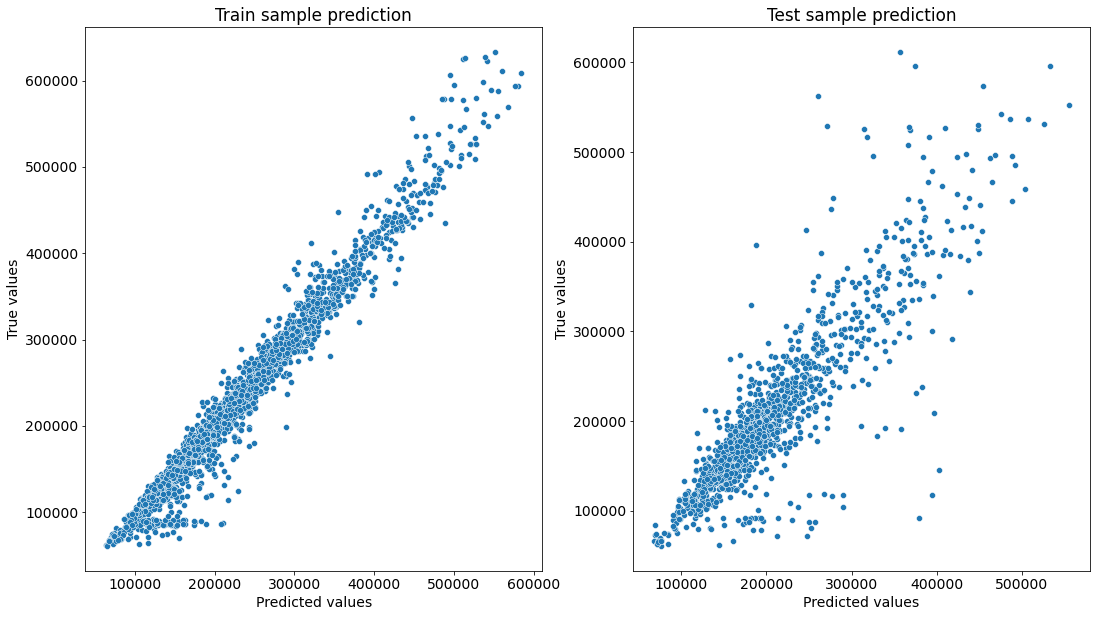

In [3197]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### Прогнозирование на тестовом датасете 

Выполнить для тестового датасета те же этапы обработки и постронияния признаков\
Не потерять и не перемешать индексы от примеров при построении прогнозов\
Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [3198]:
X_test.shape

(5000, 22)

In [3199]:
X_test

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Social_3,Helthcare_2,Shops_1,Shops_2,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,1.0,40.326128,33.009631,1.0,16,17.0,1977,0.243205,1,1,...,0,0,0,1,257,1,130461.069061,3,5,174397.952877
1,2.0,61.221971,33.009631,1.0,3,25.0,1977,0.118537,1,1,...,1,1,0,1,44,0,187717.486603,3,1,181423.633875
2,2.0,38.452646,26.290977,6.0,9,9.0,1967,0.178917,1,1,...,4,1,5,1,41,0,209521.771502,3,3,191041.542353
3,1.0,45.031389,33.009631,1.0,9,25.0,1977,0.075779,1,1,...,3,0,2,1,293,1,104300.893609,3,3,191041.542353
4,3.0,52.797939,56.404018,6.0,16,17.0,2012,0.035145,1,1,...,3,0,3,1,41,0,299589.231300,6,5,205998.692174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,38.427761,26.170250,6.0,3,12.0,1969,0.111627,1,1,...,8,2,3,1,20,0,224211.265286,3,1,181423.633875
4996,3.0,85.780610,51.107723,8.0,2,12.0,1996,0.090799,1,1,...,2,5,15,1,23,0,302272.551310,4,1,209026.030952
4997,2.0,45.594950,32.092122,6.0,2,4.0,1962,0.035145,1,1,...,3,0,3,1,41,0,210510.455372,3,1,181423.633875
4998,3.0,52.797939,53.829399,12.0,16,16.0,2008,0.158249,1,1,...,0,1,0,1,23,0,302149.979343,5,5,258809.560040


In [3200]:
predictions = rf_model.predict(X_test)
predictions

array([124417.0520028 , 214457.35810942, 194636.01568406, ...,
       187111.0847378 , 320814.63833654, 123028.95672464])

In [3201]:
submit = pd.read_csv('C:\project_data_from_kaggle/sample_submission.csv')
submit.head

<bound method NDFrame.head of          Id     Price
0      4567  200000.0
1      5925  200000.0
2       960  200000.0
3      3848  200000.0
4       746  200000.0
...     ...       ...
4995  10379  200000.0
4996  16138  200000.0
4997   3912  200000.0
4998   5722  200000.0
4999  11004  200000.0

[5000 rows x 2 columns]>

In [3202]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,124417.052003
1,5925,214457.358109
2,960,194636.015684
3,3848,135264.632881
4,746,353260.987113


In [3203]:
submit.to_csv('C:\project_data_from_kaggle/my_sample_submission.csv', index=False)